## ResNet18

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import seed_everything
from PIL import Image
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import pandas as pd
import seaborn as sn
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# PCB 데이터셋을 위한 정규화 함수를 정의합니다.
#def pcb_normalization():
#    return 

# PCBData 데이터셋 클래스를 정의합니다.
class PCBData(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NG', 'OK']
        self.files = []
        for index, label in enumerate(self.classes):
            path = os.path.join(self.root_dir, label)
            files = os.listdir(path)
            for file in files:
                self.files.append((os.path.join(path, file), index))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# LitResnet 클래스를 정의
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=2)
        #self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        #self.model.maxpool = nn.Identity()

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss
        '''
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        '''
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
        
    '''
    def train_dataloader_(self):
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        dataset = PCBDataset(data_dir='PCB_data', transform=transform)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)
        return loader
    '''
    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
            
    def evaluate2(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
        print(f"{stage}_acc", acc)

    def test_step(self, batch, batch_idx):
        self.evaluate2(batch, "test")
        
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")
        
    def setup(self, stage=None):
        # 데이터 변환 정의
        transform = transforms.Compose([
            #transforms.Resize((32, 32)),
            transforms.ToTensor(),
            #pcb_normalization(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # 데이터셋 로드
        full_dataset = PCBData(root_dir='PCBData', transform=transform)
        train_size = int(0.8 * len(full_dataset))
        val_size = int(0.1 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
        #self.train_dataset, self.test_dataset, self.val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
        #print(train_size, val_size, test_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 설정
seed_everything(7)
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

model = LitResnet(lr=0.05)
'''
trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)
'''
# ResNet 모델에 대한 Trainer 설정
trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    logger=CSVLogger(save_dir="logs/resnet18/"),  # ResNet 모델 로그를 저장할 폴더 지정
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)
# 데이터셋 준비
#model.setup()
# 훈련을 시작합니다.
trainer.fit(model)
# 테스트를 진행합니다.
trainer.test(model)

Global seed set to 7
/home/kotech/venv-sy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kotech/venv-sy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_f

Sanity Checking: 0it [00:00, ?it/s]

/home/kotech/venv-sy/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

test_acc tensor(0.8086, device='cuda:0')
test_acc tensor(0.7578, device='cuda:0')
test_acc tensor(0.8398, device='cuda:0')
test_acc tensor(0.7656, device='cuda:0')
test_acc tensor(0.8142, device='cuda:0')
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7971808910369873
        test_loss            6.388331413269043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 6.388331413269043, 'test_acc': 0.7971808910369873}]

,val_acc,val_loss,train_loss,lr-SGD,test_loss,test_acc
epoch,,,,,,
0.0,0.802353,0.430882,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,0.004083,NaN,NaN
1.0,NaN,NaN,0.325906,NaN,NaN,NaN
1.0,0.809412,0.398284,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,0.004337,NaN,NaN


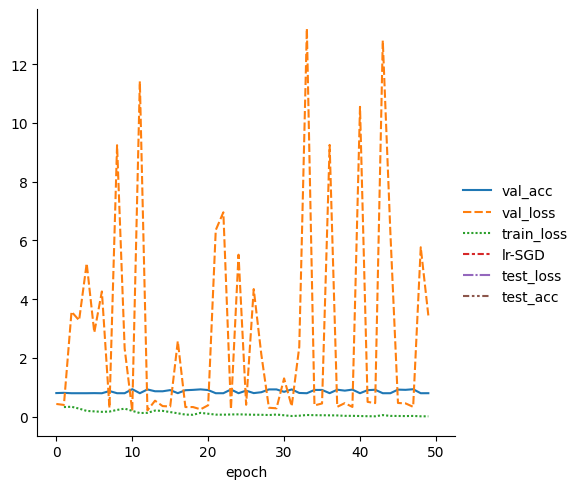

In [7]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")